In [4]:
from jitcdde import jitcdde, y, t, jitcdde_input, input
from parameters_expanded import *
import numpy as np
import matplotlib.pyplot as plt
from chspy import CubicHermiteSpline
from scipy.special import lambertw
from symengine import exp

Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.


/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")


Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.


/mnt/envs/thesis_env/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/envs/thesis_env/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


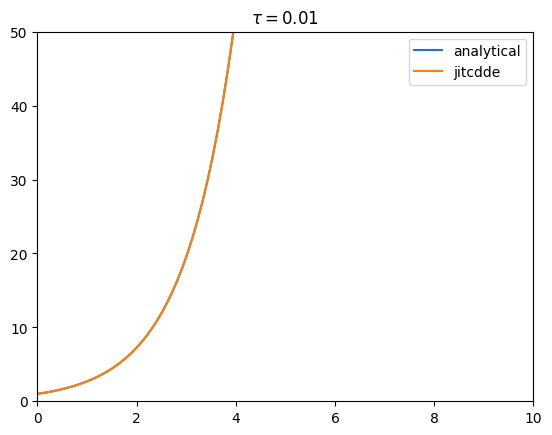

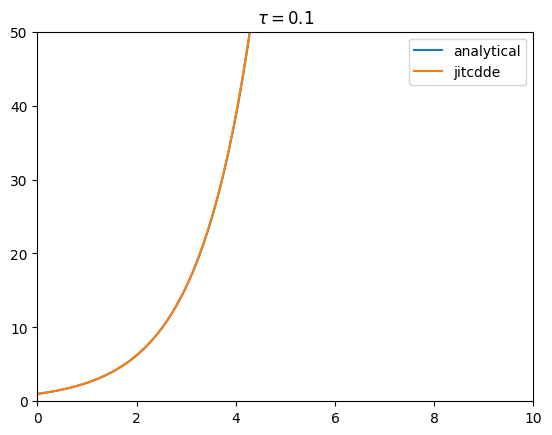

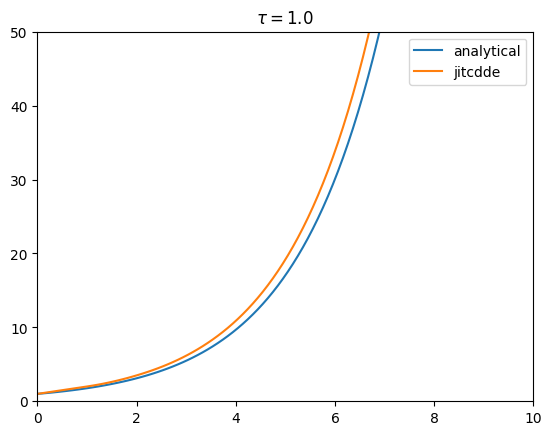

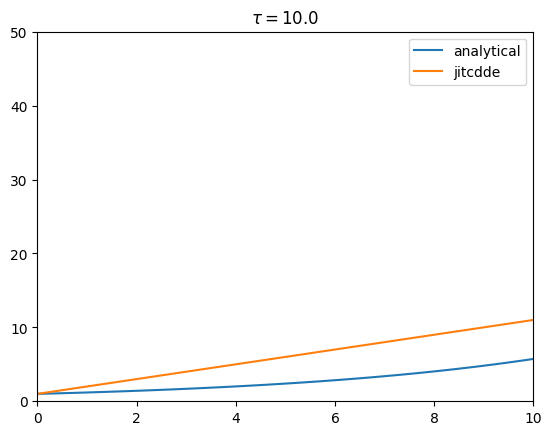

In [10]:

##############################################################################
# analytical solution
def f(t,tau):
    return np.exp(t*lambertw(tau)/tau) 

# time domain
T = np.linspace(0,10,100)

# analytical solution for different delays
taus = [0.01*(10**i) for i in range(0,4)]
Y = [f(T,taus[i]) for i in range(0,4)]


##############################################################################
# numerical solution
Y_num = []

# use iterator for easier modification of variable definitions 
nVarsMax = 100
nVarsRange = range(nVarsMax)
var = iter(nVarsRange)
# Pre-generate sets of values for each group of lambda functions
next_c = [next(var) for _ in range(6)]
fx = lambda tau=None: y(next_c[0], tau) if tau is not None else y(next_c[0])

for i in range(len(taus)):
    tau = taus[i]
    df = [fx(t-tau)]

    # runs solver
    DDE = jitcdde(df)

    # integration starts at t=0
    DDE.constant_past([1.0])
    DDE.step_on_discontinuities()

    data = []
    for time in T:
        data.append(DDE.integrate(time)[0])
          
    Y_num.append(data)

##############################################################################
# plotting 

for s in range(len(Y)):
    plt.figure(s+1)
    plt.plot(T,Y[s],label=f"analytical")
    plt.plot(T,Y_num[s],label=f"jitcdde")
    plt.legend()
    plt.xlim([0,10])
    plt.ylim([0,50])
    plt.title((r'$\tau =$')+(f"{taus[s]}"))
    plt.savefig(f"t{s}.png")
     

In [ ]:
# energy flow functions
def dQ_bf(W: float, c: float, a: y, b: y):
    '''
    Energy from bulk flow
    W: mass flow rate (kg/s)
    c: specific heat capacity (J/(kg*K))
    a: Q from node (state variable y(i))
    b: Q to node (state variable y(i))
    '''
    return (a-b)*W*c

def dQ_int(k: float, P: float, n: y):
    '''
    Energy from fission
    k: fraction of power generation in node 
    P: nominal power (MW)
    n: fractional neutron density 
    '''
    return k*P*n

def dQ_cht(a: list, b: y, hA: list):
    '''
    Energy from convective heat transfer
    a: from node(s) (state variable(s) y(i))
    b: to node (state variable y(i))
    hA: convective heat transfer coefficient(s) * wetted area(s) (MW/C)
    f: fractional adjustments
    '''
    tot = 0.0
    for i in range(len(a)):
        tot += hA[i]*(a[i]-b)
    return tot

def Q_to_T(q,m,scp):
    '''
    Translate internal energy to temperature
    m: node mass (kg)
    scp: node specific heat capacity (MJ/(kg*K))
    '''

    return q/(m*scp)

def nFission(k,b,l):
    '''
    Change in neutron population density (1/cm^3) due to prompt fission
    k: multiplication factor (state variable y(i))
    b: total delayed neutron fraction
    l: prompt neutron lifetime (s)
    '''
    return (k-b)*k/l

def nDelayed(L,C):
    '''
    Change in neutron population density (1/cm^3) due delayed neutrons
    L: vector containing decay constants for neutron precursor groups
    C: vector whose i^th element contains the concentration of the i^th precursor group
    '''
    return np.dot(L,C)
     
def precursorGen(k,b,l):
    '''
    Change in precursor concentration (1/cm^3) 
    k: multiplication factor (state variable(y(i)))
    b: fraction of delayed neutrons belonging to group 
    l: prompt neutron lifetime
    '''
    return k*b/l

def precursorDecay(l,c):
    '''
    Precursor loss due to decay 
    l: decay constant
    c: precursor concentration (state variable (y(i)))
    '''
    return l*c

def outflowLoss(c,tau):
    '''
    precursor loss due to outflor
    c: precursor concentration (state variable (y(i)))
    tau: core transit time (s)
    '''
    return c/tau

def inflowGain(c,tl,l,tc):
    '''
    precursor gain from inflow
    c: precursor concentration (state variable (y(i)))
    tl: loop transit time (s)
    l: decay constant
    tc: core transit time (s)
    '''
    return c*np.exp(-l*tl)/tc  

def feedback(A,T):
    '''
    reactivity feedback 
    A: list of feedback coefficients
    T: list of lists containing relevant temperatures 
    '''
    fb = 0.0
    for i in enumerate(T):
        f = len(i[1])
        for j in i[1]:
            fb += (j/f)*A[i[0]]
    return fb

In [ ]:
# initialize state variables, naming convention: [coponent_(material->material)[loop][index]][_(material)[index]]
# e.g. fuel->helium heat exchanger 1, fuel node 1                  = hx_fh1_f1
# e.g. helium->water heat eachanger 1, helium node 2, coolant loop = hx_hwc1_h1

# use iterator for easier modification of variable definitions 
nVarsMax = 100
nVarsRange = range(nVarsMax)
var = iter(nVarsRange)

# Pre-generate sets of values for each group of lambda functions
next_c = [next(var) for _ in range(6)]
next_fh1 = [next(var) for _ in range(5)]
next_fh2 = [next(var) for _ in range(5)]
next_ch1 = [next(var) for _ in range(5)]
next_ch2 = [next(var) for _ in range(5)]
next_hwf1 = [next(var) for _ in range(5)]
next_hwf2 = [next(var) for _ in range(5)]
next_hwc1 = [next(var) for _ in range(5)]
next_hwc2 = [next(var) for _ in range(5)]
next_neutronics = [next(var) for _ in range(8)]

# state variable wrappers (uses lambda function wrappers to account for delays)
# core 
c_f1 = lambda tau=None: y(next_c[0], tau) if tau is not None else y(next_c[0])
c_f2 = lambda tau=None: y(next_c[1], tau) if tau is not None else y(next_c[1])
c_t1 = lambda tau=None: y(next_c[2], tau) if tau is not None else y(next_c[2])
c_c1 = lambda tau=None: y(next_c[3], tau) if tau is not None else y(next_c[3])
c_c2 = lambda tau=None: y(next_c[4], tau) if tau is not None else y(next_c[4])
c_m1 = lambda tau=None: y(next_c[5], tau) if tau is not None else y(next_c[5])
# fh hx1
hx_fh1_f1 = lambda tau=None: y(next_fh1[0], tau) if tau is not None else y(next_fh1[0])
hx_fh1_f2 = lambda tau=None: y(next_fh1[1], tau) if tau is not None else y(next_fh1[1])
hx_fh1_t1 = lambda tau=None: y(next_fh1[2], tau) if tau is not None else y(next_fh1[2])
hx_fh1_h1 = lambda tau=None: y(next_fh1[3], tau) if tau is not None else y(next_fh1[3])
hx_fh1_h2 = lambda tau=None: y(next_fh1[4], tau) if tau is not None else y(next_fh1[4])
# fh hx2
hx_fh2_f1 = lambda tau=None: y(next_fh2[0], tau) if tau is not None else y(next_fh2[0])
hx_fh2_f2 = lambda tau=None: y(next_fh2[1], tau) if tau is not None else y(next_fh2[1])
hx_fh2_t1 = lambda tau=None: y(next_fh2[2], tau) if tau is not None else y(next_fh2[2])
hx_fh2_h1 = lambda tau=None: y(next_fh2[3], tau) if tau is not None else y(next_fh2[3])
hx_fh2_h2 = lambda tau=None: y(next_fh2[4], tau) if tau is not None else y(next_fh2[4])
# ch hx1
hx_ch1_c1 = lambda tau=None: y(next_ch1[0], tau) if tau is not None else y(next_ch1[0])
hx_ch1_c2 = lambda tau=None: y(next_ch1[1], tau) if tau is not None else y(next_ch1[1])
hx_ch1_t1 = lambda tau=None: y(next_ch1[2], tau) if tau is not None else y(next_ch1[2])
hx_ch1_h1 = lambda tau=None: y(next_ch1[3], tau) if tau is not None else y(next_ch1[3])
hx_ch1_h2 = lambda tau=None: y(next_ch1[4], tau) if tau is not None else y(next_ch1[4])
# ch hx2
hx_ch2_c1 = lambda tau=None: y(next_ch2[0], tau) if tau is not None else y(next_ch2[0])
hx_ch2_c2 = lambda tau=None: y(next_ch2[1], tau) if tau is not None else y(next_ch2[1])
hx_ch2_t1 = lambda tau=None: y(next_ch2[2], tau) if tau is not None else y(next_ch2[2])
hx_ch2_h1 = lambda tau=None: y(next_ch2[3], tau) if tau is not None else y(next_ch2[3])
hx_ch2_h2 = lambda tau=None: y(next_ch2[4], tau) if tau is not None else y(next_ch2[4])
# hw (fuel loop) hx1
hx_hwf1_h1 = lambda tau=None: y(next_hwf1[0], tau) if tau is not None else y(next_hwf1[0])
hx_hwf1_h2 = lambda tau=None: y(next_hwf1[1], tau) if tau is not None else y(next_hwf1[1])
hx_hwf1_t1 = lambda tau=None: y(next_hwf1[2], tau) if tau is not None else y(next_hwf1[2])
hx_hwf1_w1 = lambda tau=None: y(next_hwf1[3], tau) if tau is not None else y(next_hwf1[3])
hx_hwf1_w2 = lambda tau=None: y(next_hwf1[4], tau) if tau is not None else y(next_hwf1[4])
# hw (fuel loop) hx2
hx_hwf2_h1 = lambda tau=None: y(next_hwf2[0], tau) if tau is not None else y(next_hwf2[0])
hx_hwf2_h2 = lambda tau=None: y(next_hwf2[1], tau) if tau is not None else y(next_hwf2[1])
hx_hwf2_t1 = lambda tau=None: y(next_hwf2[2], tau) if tau is not None else y(next_hwf2[2])
hx_hwf2_w1 = lambda tau=None: y(next_hwf2[3], tau) if tau is not None else y(next_hwf2[3])
hx_hwf2_w2 = lambda tau=None: y(next_hwf2[4], tau) if tau is not None else y(next_hwf2[4])
# hw (coolant loop) hx1
hx_hwc1_h1 = lambda tau=None: y(next_hwc1[0], tau) if tau is not None else y(next_hwc1[0])
hx_hwc1_h2 = lambda tau=None: y(next_hwc1[1], tau) if tau is not None else y(next_hwc1[1])
hx_hwc1_t1 = lambda tau=None: y(next_hwc1[2], tau) if tau is not None else y(next_hwc1[2])
hx_hwc1_w1 = lambda tau=None: y(next_hwc1[3], tau) if tau is not None else y(next_hwc1[3])
hx_hwc1_w2 = lambda tau=None: y(next_hwc1[4], tau) if tau is not None else y(next_hwc1[4])
# hw (coolant loop) hx2
hx_hwc2_h1 = lambda tau=None: y(next_hwc2[0], tau) if tau is not None else y(next_hwc2[0])
hx_hwc2_h2 = lambda tau=None: y(next_hwc2[1], tau) if tau is not None else y(next_hwc2[1])
hx_hwc2_t1 = lambda tau=None: y(next_hwc2[2], tau) if tau is not None else y(next_hwc2[2])
hx_hwc2_w1 = lambda tau=None: y(next_hwc2[3], tau) if tau is not None else y(next_hwc2[3])
hx_hwc2_w2 = lambda tau=None: y(next_hwc2[4], tau) if tau is not None else y(next_hwc2[4])
#neutronics
n = lambda tau=None: y(next_neutronics[0], tau) if tau is not None else y(next_neutronics[0])
C1 = lambda tau=None: y(next_neutronics[1], tau) if tau is not None else y(next_neutronics[1])
C2 = lambda tau=None: y(next_neutronics[2], tau) if tau is not None else y(next_neutronics[2])
C3 = lambda tau=None: y(next_neutronics[3], tau) if tau is not None else y(next_neutronics[3])
C4 = lambda tau=None: y(next_neutronics[4], tau) if tau is not None else y(next_neutronics[4])
C5 = lambda tau=None: y(next_neutronics[5], tau) if tau is not None else y(next_neutronics[5])
C6 = lambda tau=None: y(next_neutronics[6], tau) if tau is not None else y(next_neutronics[6])
rho = lambda tau=None: y(next_neutronics[7], tau) if tau is not None else y(next_neutronics[7])


In [ ]:
# define derivatives 
system = []
s0 = []

# CORE
dc_f1 = dQ_cht([c_t1()],c_f1(),[hA_ft_c]) + dQ_bf(W_f,scp_f,(hx_fh1_f2(tau_hx_c_f)+hx_fh2_f2(tau_hx_c_f))/2,c_f1()) + dQ_int(k_f1,P,n())
dc_f2 = dQ_cht([c_t1()],c_f2(),[hA_ft_c]) + dQ_bf(W_f,scp_f,c_f1(),c_f2())                                          + dQ_int(k_f2,P,n())
dc_t1 = dQ_cht([c_f1(),c_f2(),c_c1(),c_c2()],c_t1(),[hA_ft_c,hA_ft_c,hA_tc_c,hA_tc_c]) 
dc_c1 = dQ_cht([c_t1(),c_m1()],c_c1(),[hA_tc_c,hA_mc_c]) + dQ_bf(W_c,scp_c,(hx_ch1_c2(tau_hx_c_c)+hx_ch2_c2(tau_hx_c_c))/2,c_c1()) 
dc_c2 = dQ_cht([c_t1(),c_m1()],c_c2(),[hA_tc_c,hA_mc_c]) + dQ_bf(W_c,scp_c,c_c1(),c_c2())                           
dc_m1 = dQ_cht([c_c1(),c_c2()],c_m1(),[hA_mc_c,hA_mc_c])                                                            + dQ_int(k_m,P,n())
# add to state vector and set initial state
[system.append(d) for d in [dc_f1,dc_f2,dc_t1,dc_c1,dc_c2,dc_m1]] 
[s0.append(d) for d in [T0_c_f1/(2*mcp_f_c),T0_c_f2/(2*mcp_f_c),T0_c_t1/mcp_t_c,T0_c_c1/(2*mcp_c_c),T0_c_c2/(2*mcp_c_c),T0_c_m/mcp_m_c]]

# FUEL-HELIUM HX1
dhx_fh1_f1 = dQ_cht([hx_fh1_t1()],hx_fh1_f1(),[hA_ft_hx]) + dQ_bf(W_f,scp_f,c_f2(tau_c_hx_f),hx_fh1_f1())
dhx_fh1_f2 = dQ_cht([hx_fh1_t1()],hx_fh1_f2(),[hA_ft_hx]) + dQ_bf(W_f,scp_f,hx_fh1_f1(),hx_fh1_f2())
dhx_fh1_t1 = dQ_cht([hx_fh1_f1(),hx_fh1_f2(),hx_fh1_h1(),hx_fh1_h2()],hx_fh1_t1(),[hA_ft_hx,hA_ft_hx,hA_ht_hx,hA_ht_hx])
dhx_fh1_h1 = dQ_cht([hx_fh1_t1()],hx_fh1_h1(),[hA_ht_hx]) + dQ_bf(W_h_fh,scp_h,hx_hwf2_h2(tau_h),hx_fh1_h1())
dhx_fh1_h2 = dQ_cht([hx_fh1_t1()],hx_fh1_h2(),[hA_ht_hx]) + dQ_bf(W_h_fh,scp_h,hx_fh1_h1(),hx_fh1_h2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_fh1_f1,dhx_fh1_f2,dhx_fh1_t1,dhx_fh1_h1,dhx_fh1_h2]]
[s0.append(d) for d in [T0_hfh_f1/(2*mcp_f_hx),T0_hfh_f2/(2*mcp_f_hx),T0_hfh_t1/mcp_t_hx,T0_hfh_h1/(2*mcp_h_hxfh),T0_hfh_h2/(2*mcp_h_hxfh)]]

# FUEL-HELIUM HX2
dhx_fh2_f1 = dQ_cht([hx_fh2_t1()],hx_fh2_f1(),[hA_ft_hx]) + dQ_bf(W_f,scp_f,c_f2(tau_c_hx_f),hx_fh2_f1())
dhx_fh2_f2 = dQ_cht([hx_fh2_t1()],hx_fh2_f2(),[hA_ft_hx]) + dQ_bf(W_f,scp_f,hx_fh2_f1(),hx_fh2_f2())
dhx_fh2_t1 = dQ_cht([hx_fh2_f1(),hx_fh2_f2(),hx_fh2_h1(),hx_fh2_h2()],hx_fh2_t1(),[hA_ft_hx,hA_ft_hx,hA_ht_hx,hA_ht_hx])
dhx_fh2_h1 = dQ_cht([hx_fh2_t1()],hx_fh2_h1(),[hA_ht_hx]) + dQ_bf(W_h_fh,scp_h,hx_hwf1_h2(),hx_fh2_h1())
dhx_fh2_h2 = dQ_cht([hx_fh2_t1()],hx_fh2_h2(),[hA_ht_hx]) + dQ_bf(W_h_fh,scp_h,hx_fh2_h1(),hx_fh2_h2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_fh2_f1,dhx_fh2_f2,dhx_fh2_t1,dhx_fh2_h1,dhx_fh2_h2]]
[s0.append(d) for d in [T0_hfh_f1/(2*mcp_f_hx),T0_hfh_f2/(2*mcp_f_hx),T0_hfh_t1/mcp_t_hx,T0_hfh_h1/(2*mcp_h_hxfh),T0_hfh_h2/(2*mcp_h_hxfh)]]

# COOLANT-HELIUM HX1
dhx_ch1_c1 = dQ_cht([hx_ch1_t1()],hx_ch1_c1(),[hA_ct_hx]) + dQ_bf(W_c,scp_c,c_c2(tau_c_hx_f),hx_ch1_c1())
dhx_ch1_c2 = dQ_cht([hx_ch1_t1()],hx_ch1_c2(),[hA_ct_hx]) + dQ_bf(W_c,scp_c,hx_ch1_c1(),hx_ch1_c2())
dhx_ch1_t1 = dQ_cht([hx_ch1_c1(),hx_ch1_c2(),hx_ch1_h1(),hx_ch1_h2()],hx_ch1_t1(),[hA_ct_hx,hA_ct_hx,hA_th_hxch,hA_th_hxch])
dhx_ch1_h1 = dQ_cht([hx_ch1_t1()],hx_ch1_h1(),[hA_th_hxch]) + dQ_bf(W_h_ch,scp_h,hx_hwc1_h2(tau_h),hx_ch1_h1())
dhx_ch1_h2 = dQ_cht([hx_ch1_t1()],hx_ch1_h2(),[hA_th_hxch]) + dQ_bf(W_h_ch,scp_h,hx_ch1_h1(),hx_ch1_h2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_ch1_c1,dhx_ch1_c2,dhx_ch1_t1,dhx_ch1_h1,dhx_ch1_h2]]
[s0.append(d) for d in [T0_hch_c1/(2*mcp_h_c),T0_hch_c2/(2*mcp_h_c),T0_hch_t1/mcp_t_hxch,T0_hch_h1/(2*mcp_h_hxch),T0_hch_h2/(2*mcp_h_hxch)]]

# COOLANT-HELIUM HX2
dhx_ch2_c1 = dQ_cht([hx_ch2_t1()],hx_ch2_c1(),[hA_ct_hx]) + dQ_bf(W_c,scp_c,c_c2(tau_c_hx_f),hx_ch2_c1())
dhx_ch2_c2 = dQ_cht([hx_ch2_t1()],hx_ch2_c2(),[hA_ct_hx]) + dQ_bf(W_c,scp_c,hx_ch2_c1(),hx_ch2_c2())
dhx_ch2_t1 = dQ_cht([hx_ch2_c1(),hx_ch2_c2(),hx_ch2_h1(),hx_ch2_h2()],hx_ch2_t1(),[hA_ct_hx,hA_ct_hx,hA_th_hxch,hA_th_hxch])
dhx_ch2_h1 = dQ_cht([hx_ch2_t1()],hx_ch2_h1(),[hA_th_hxch]) + dQ_bf(W_h_ch,scp_h,hx_hwc2_h2(tau_h),hx_ch2_h1())
dhx_ch2_h2 = dQ_cht([hx_ch2_t1()],hx_ch2_h2(),[hA_th_hxch]) + dQ_bf(W_h_ch,scp_h,hx_ch2_h1(),hx_ch2_h2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_ch2_c1,dhx_ch2_c2,dhx_ch2_t1,dhx_ch2_h1,dhx_ch2_h2]]
[s0.append(d) for d in [T0_hch_c1/(2*mcp_h_c),T0_hch_c2/(2*mcp_h_c),T0_hch_t1/mcp_t_hxch,T0_hch_h1/(2*mcp_h_hxch),T0_hch_h2/(2*mcp_h_hxch)]]

# HELIUM-WATER HX1 (FUEL LOOP)
dhx_hwf1_h1 = dQ_cht([hx_hwf1_t1()],hx_hwf1_h1(),[hA_ht_hxhw]) + dQ_bf(W_h_ch,scp_h,hx_fh1_h2(),hx_hwf1_h1())
dhx_hwf1_h2 = dQ_cht([hx_hwf1_t1()],hx_hwf1_h2(),[hA_ht_hxhw]) + dQ_bf(W_h_ch,scp_h,hx_hwf1_h1(),hx_hwf1_h2())
dhx_hwf1_t1 = dQ_cht([hx_hwf1_h1(),hx_hwf1_h2(),hx_hwf1_w1(),hx_hwf1_w2()],hx_hwf1_t1(),[hA_ht_hxhw,hA_ht_hxhw,hA_tw_hxhw,hA_tw_hxhw])
dhx_hwf1_w1 = dQ_cht([hx_hwf1_t1()],hx_hwf1_w1(),[hA_tw_hxhw]) + dQ_bf(W_hhwf_w,scp_w,T0_hhwf_w1*mcp_w,hx_hwf1_w1())
dhx_hwf1_w2 = dQ_cht([hx_hwf1_t1()],hx_hwf1_w2(),[hA_tw_hxhw]) + dQ_bf(W_hhwf_w,scp_w,hx_hwf1_w1(),hx_hwf1_w2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_hwf1_h1,dhx_hwf1_h2,dhx_hwf1_t1,dhx_hwf1_w1,dhx_hwf1_w2]]
[s0.append(d) for d in [T0_hhwf_h1/(2*mcp_h_hxhw),T0_hhwf_h2/(2*mcp_h_hxhw),T0_hhwf_t1/mcp_t_hxhw,T0_hhwf_w1/(2*mcp_w),T0_hhwf_w2/(2*mcp_w)]]

# HELIUM-WATER HX2 (FUEL LOOP)
dhx_hwf2_h1 = dQ_cht([hx_hwf2_t1()],hx_hwf2_h1(),[hA_ht_hxhw]) + dQ_bf(W_h_ch,scp_h,hx_fh2_h2(),hx_hwf2_h1())
dhx_hwf2_h2 = dQ_cht([hx_hwf2_t1()],hx_hwf2_h2(),[hA_ht_hxhw]) + dQ_bf(W_h_ch,scp_h,hx_hwf2_h1(),hx_hwf2_h2())
dhx_hwf2_t1 = dQ_cht([hx_hwf2_h1(),hx_hwf2_h2(),hx_hwf2_w1(),hx_hwf2_w2()],hx_hwf2_t1(),[hA_ht_hxhw,hA_ht_hxhw,hA_tw_hxhw,hA_tw_hxhw])
dhx_hwf2_w1 = dQ_cht([hx_hwf2_t1()],hx_hwf2_w1(),[hA_tw_hxhw]) + dQ_bf(W_hhwf_w,scp_w,T0_hhwf_w1*mcp_w,hx_hwf2_w1())
dhx_hwf2_w2 = dQ_cht([hx_hwf2_t1()],hx_hwf2_w2(),[hA_tw_hxhw]) + dQ_bf(W_hhwf_w,scp_w,hx_hwf2_w1(),hx_hwf2_w2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_hwf2_h1,dhx_hwf2_h2,dhx_hwf2_t1,dhx_hwf2_w1,dhx_hwf2_w2]]
[s0.append(d) for d in [T0_hhwf_h1/(2*mcp_h_hxhw),T0_hhwf_h2/(2*mcp_h_hxhw),T0_hhwf_t1/mcp_t_hxhw,T0_hhwf_w1/(2*mcp_w),T0_hhwf_w2/(2*mcp_w)]]

# HELIUM-WATER HX1 (COOLANT LOOP)
dhx_hwc1_h1 = dQ_cht([hx_hwc1_t1()],hx_hwc1_h1(),[hA_ht_hxhwc]) + dQ_bf(W_h_ch,scp_h,hx_ch1_h2(),hx_hwc1_h1())
dhx_hwc1_h2 = dQ_cht([hx_hwc1_t1()],hx_hwc1_h2(),[hA_ht_hxhwc]) + dQ_bf(W_h_ch,scp_h,hx_hwc1_h1(),hx_hwc1_h2())
dhx_hwc1_t1 = dQ_cht([hx_hwc1_h1(),hx_hwc1_h2(),hx_hwc1_w1(),hx_hwc1_w2()],hx_hwc1_t1(),[hA_ht_hxhwc,hA_ht_hxhwc,hA_tw_hxhwc,hA_tw_hxhwc])
dhx_hwc1_w1 = dQ_cht([hx_hwc1_t1()],hx_hwc1_w1(),[hA_tw_hxhwc]) + dQ_bf(W_hhwc_w,scp_w,T0_hhwc_w1*mcp_w_hxhwc,hx_hwc1_w1())
dhx_hwc1_w2 = dQ_cht([hx_hwc1_t1()],hx_hwc1_w2(),[hA_tw_hxhwc]) + dQ_bf(W_hhwc_w,scp_w,hx_hwc1_w1(),hx_hwc1_w2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_hwc1_h1,dhx_hwc1_h2,dhx_hwc1_t1,dhx_hwc1_w1,dhx_hwc1_w2]]
[s0.append(d) for d in [T0_hhwc_h1/(2*mcp_h_hxhwc),T0_hhwc_h2/(2*mcp_h_hxhwc),T0_hhwc_t1/mcp_t_hxhwc,T0_hhwc_w1/(2*mcp_w_hxhwc),T0_hhwc_w2/(2*mcp_w_hxhwc)]]

# HELIUM-WATER HX2 (COOLANT LOOP)
dhx_hwc2_h1 = dQ_cht([hx_hwc2_t1()],hx_hwc2_h1(),[hA_ht_hxhwc]) + dQ_bf(W_h_ch,scp_h,hx_ch2_h2(),hx_hwc2_h1())
dhx_hwc2_h2 = dQ_cht([hx_hwc2_t1()],hx_hwc2_h2(),[hA_ht_hxhwc]) + dQ_bf(W_h_ch,scp_h,hx_hwc2_h1(),hx_hwc2_h2())
dhx_hwc2_t1 = dQ_cht([hx_hwc2_h1(),hx_hwc2_h2(),hx_hwc2_w1(),hx_hwc2_w2()],hx_hwc2_t1(),[hA_ht_hxhwc,hA_ht_hxhwc,hA_tw_hxhwc,hA_tw_hxhwc])
dhx_hwc2_w1 = dQ_cht([hx_hwc2_t1()],hx_hwc2_w1(),[hA_tw_hxhwc]) + dQ_bf(W_hhwc_w,scp_w,T0_hhwc_w1*mcp_w_hxhwc,hx_hwc2_w1())
dhx_hwc2_w2 = dQ_cht([hx_hwc2_t1()],hx_hwc2_w2(),[hA_tw_hxhwc]) + dQ_bf(W_hhwc_w,scp_w,hx_hwc2_w1(),hx_hwc2_w2())
# add to state vector and set initial state
[system.append(d) for d in [dhx_hwc2_h1,dhx_hwc2_h2,dhx_hwc2_t1,dhx_hwc2_w1,dhx_hwc2_w2]]
[s0.append(d) for d in [T0_hhwc_h1/(2*mcp_h_hxhwc),T0_hhwc_h2/(2*mcp_h_hxhwc),T0_hhwc_t1/mcp_t_hxhwc,T0_hhwc_w1/(2*mcp_w_hxhwc),T0_hhwc_w2/(2*mcp_w_hxhwc)]]

# neutronics
dn = nFission(n(),beta_t,Lam) + nDelayed(lam,[C1(),C2(),C2(),C4(),C5(),C6()])
dC1 = precursorGen(n(),beta[0],Lam) - precursorDecay(lam[0],C1()) - outflowLoss(C1(),tau_c) + inflowGain(C1(),tau_l,lam[0],tau_c)
dC2 = precursorGen(n(),beta[1],Lam) - precursorDecay(lam[1],C2()) - outflowLoss(C2(),tau_c) + inflowGain(C2(),tau_l,lam[1],tau_c)
dC3 = precursorGen(n(),beta[2],Lam) - precursorDecay(lam[2],C3()) - outflowLoss(C3(),tau_c) + inflowGain(C3(),tau_l,lam[2],tau_c)
dC4 = precursorGen(n(),beta[3],Lam) - precursorDecay(lam[3],C4()) - outflowLoss(C4(),tau_c) + inflowGain(C4(),tau_l,lam[3],tau_c)
dC5 = precursorGen(n(),beta[4],Lam) - precursorDecay(lam[4],C5()) - outflowLoss(C5(),tau_c) + inflowGain(C5(),tau_l,lam[4],tau_c)
dC6 = precursorGen(n(),beta[5],Lam) - precursorDecay(lam[5],C6()) - outflowLoss(C6(),tau_c) + inflowGain(C6(),tau_l,lam[5],tau_c)
drho = feedback([a_f,a_b,a_c],[[c_f1(),c_f2()],[c_m1()],[c_c1(),c_c2()]])
# add to state vector and set initial state
[system.append(d) for d in [dn,dC1,dC2,dC3,dC4,dC5,dC6,drho]]
[s0.append(d) for d in [n_frac0,C0[0],C0[1],C0[2],C0[3],C0[4],C0[5],0.0]]

Initial values & solve

In [ ]:
# instantiate jitcdde object
DDE = jitcdde(system)

# set initial conditions
DDE.constant_past(s0)

#DDE.set_integration_parameters(atol=1e-10, rtol=1e-05, first_step=1.0, min_step=1e-11, max_step=10.0, decrease_threshold=1.1, 
#                           increase_threshold=0.5, safety_factor=0.9, max_factor=5.0, min_factor=0.2, pws_factor=3, 
#                           pws_atol=0.0, pws_rtol=1e-05, pws_max_iterations=10, pws_base_increase_chance=0.1, pws_fuzzy_increase=False)
#
# DDE.step_on_discontinuities()

# jitcdde solver parameters 
t0 = 0.0
tf = 1000.00
T = np.arange(t0,tf,0.01)

sol_jit = []
for t_x in T:
    sol_jit.append(DDE.integrate(t_x))

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,18))

t_0 = 0.0
t_f = 250

p_error = 0.17

axs[0,0].set_xlim([t_0,t_f])
axs[0,0].plot(T,[s[0] for s in sol_jit],label="core f1") 
axs[0,0].plot(T,[s[1] for s in sol_jit],label="core f2") 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="core t1")  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="core c1")
axs[0,0].plot(T,[s[4] for s in sol_jit],label="core c2")
axs[0,0].plot(T,[s[5] for s in sol_jit],label="core m")
axs[0,0].legend()
axs[0,0].set_title("Core Node Temperatures (K)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


axs[0,1].set_xlim([t_0,t_f])
# axs[0,1].set_ylim([650,750])
axs[0,1].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0,1].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0,1].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0,1].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0,1].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0,1].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0,1].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0,1].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0,1].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0,1].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")

axs[0,1].legend()
axs[0,1].set_title("HX Fuel->Helium Node Temperatures (K)")
#axs[0,1].tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

axs[0,2].set_xlim([t_0,t_f])
axs[0,2].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[0,2].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[0,2].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[0,2].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[0,2].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[0,2].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[0,2].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[0,2].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[0,2].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[0,2].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[0,2].legend()
axs[0,2].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1,1].set_xlim([t_0,t_f])
axs[1,1].plot(T,[s[11] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[12] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[13] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[14] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[15] for s in sol_jit],label="hx_ch h2")
axs[1,1].plot(T,[s[39] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[40] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[41] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[42] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[43] for s in sol_jit],label="hx_ch h2")
axs[1,1].legend()
axs[1,1].legend()
axs[1,1].set_title("HX Coolant->Helium Node Temperatures (K)")

# fuel temps
axs[1,2].set_xlim([t_0,t_f])
axs[1,2].plot(T,[s[21] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[22] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[23] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[24] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[25] for s in sol_jit],label="hx_hwc w2")
axs[1,2].plot(T,[s[49] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[50] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[51] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[52] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[53] for s in sol_jit],label="hx_hwc w2")
axs[1,2].legend()
axs[1,2].set_title("HX Helium->Water (Coolant Loop) Node Temperatures (K)")

axs[1,0].plot(T,[s[26] for s in sol_jit],label="n") 
axs[1,0].plot(T,[(1+p_error)*s[26] for s in sol_jit],linestyle="--",label="+20%") 
axs[1,0].plot(T,[(1-p_error)*s[26] for s in sol_jit],linestyle="--",label="-20%") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")
axs[1,0].set_xlim([t_0,t_f])
axs[1,0].legend()

axs[2,0].plot(T,[s[33] for s in sol_jit],label="n") 
axs[2,0].set_xlabel("t (s)")
axs[2,0].set_title(r"$\rho$")
axs[2,0].set_xlim([t_0,t_f])

axs[2,1].plot(T,[s[27] for s in sol_jit],label="C1") 
axs[2,1].plot(T,[s[28] for s in sol_jit],label="C2") 
axs[2,1].plot(T,[s[29] for s in sol_jit],label="C3")  
axs[2,1].plot(T,[s[30] for s in sol_jit],label="C4")
axs[2,1].plot(T,[s[31] for s in sol_jit],label="C5")
axs[2,1].plot(T,[s[32] for s in sol_jit],label="C6")
axs[2,1].legend()
axs[2,1].set_xlabel("t (s)")
axs[2,1].set_yscale("log")
axs[2,1].set_ylabel(r"concentration (1/cm$^3$)")
axs[2,1].legend(loc="right")
axs[2,1].set_title("Precursor Concentrations")
axs[2,1].set_xlim([t_0,t_f])


In [ ]:
print((1-p_error)*sol_jit[-1][26])
print(sol_jit[-1][26])
print((1+p_error)*sol_jit[-1][26])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

axs[0].set_xlim([t_0,10])
# axs[0,1].set_ylim([650,750])
axs[0].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")
axs[0].set_title("HX Fuel->Helium Node Temperatures (K)")
axs[0].legend(loc="right")
axs[0].set_xlabel(r"$t$(s)")

axs[1].set_xlim([t_0,50])
axs[1].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[1].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[1].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[1].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[1].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[1].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[1].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[1].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[1].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[1].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[1].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[1].legend()
axs[1].set_xlabel(r"$t$(s)")

In [ ]:
# power generation from fission 

# core power generation
pow_f1 = [k_f1*P*s[26] for s in sol_jit]
pow_f2 = [k_f2*P*s[26] for s in sol_jit]
tot_pow = np.add(pow_f1,pow_f2)

# heat extracted by fuel-helium hx
fh_ex = [(s[1]-s[0])*W_f*scp_f for s in sol_jit]

# heat extracted by coolant-helium hx
ch_ex = [(s[4]-s[3])*W_c*scp_c for s in sol_jit]

# helium-> water (fuel loop)
hwf_ex = [(s[10]-s[9])*W_h_fh*scp_h for s in sol_jit]

# helium-> water (coolant loop)
hwc_ex = [(s[15]-s[14])*W_h_ch*scp_h for s in sol_jit]

tot_ex = [fh_ex[i]+ch_ex[i]+hwf_ex[i]+hwc_ex[i] for i in range(len(sol_jit))]

plt.plot(T,tot_pow,label="core power generation")
plt.plot(T,fh_ex,label="fh hx extraction")
plt.plot(T,ch_ex,label="ch hx extraction")
plt.plot(T,hwf_ex,label="hwf hx extraction")
plt.plot(T,hwc_ex,label="hwc hx extraction")
plt.plot(T,tot_ex,label="total extraction",linestyle="--")
plt.legend()


In [ ]:
rate_ex = np.divide(tot_ex,tot_pow)
plt.plot(T,rate_ex)
plt.ylim([0,1.2])